In [1]:
%pip install pandas numpy matplotlib seaborn
%pip install networkx
%pip install scipy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


JADE Dataset Sample:


,Timestamp,Sender,Receiver,ConversationID,Performative,RTT_ms,MessageSize_bytes,Success,AdditionalInfo,Ontology,Platform
0,2025-04-28 23:27:03.749228800+00:00,Profesor0,SalaE6,neg-ROJAS RODRIGUEZ RO-SalaE6-1745882823692,PROPOSE,55.021,750,True,{},classroom-availability,JADE
1,2025-04-28 23:27:03.762268700+00:00,Profesor0,SalaLC6,neg-ROJAS RODRIGUEZ RO-SalaLC6-1745882823692,PROPOSE,69.252,751,True,{},classroom-availability,JADE
2,2025-04-28 23:27:03.762268700+00:00,Profesor0,SalaIC3,neg-ROJAS RODRIGUEZ RO-SalaIC3-1745882823692,PROPOSE,69.776,751,True,{},classroom-availability,JADE
3,2025-04-28 23:27:03.763267500+00:00,Profesor0,SalaLAMB,neg-ROJAS RODRIGUEZ RO-SalaLAMB-1745882823692,PROPOSE,70.523,752,True,{},classroom-availability,JADE
4,2025-04-28 23:27:03.763267500+00:00,Profesor0,SalaCM3,neg-ROJAS RODRIGUEZ RO-SalaCM3-1745882823683,PROPOSE,71.594,751,True,{},classroom-availability,JADE



SPADE Dataset Sample:


,Timestamp,Sender,Receiver,ConversationID,Performative,RTT_ms,MessageSize_bytes,Success,AdditionalInfo,Ontology,Platform
0,2025-04-27 15:39:08.601137,ROJAS RODRIGUEZ RO,salacm3@localhost,cfp-ac805810-5a62-4225-8ed4-588ff0e27f26,propose,135.671,355,True,NaN,classroom-availability,SPADE
1,2025-04-27 15:39:08.718147,ROJAS RODRIGUEZ RO,salalc6@localhost,cfp-5dbf1d21-3da7-4d44-8b71-caff62cb2a44,propose,251.756,355,True,NaN,classroom-availability,SPADE
2,2025-04-27 15:39:08.869935,ROJAS RODRIGUEZ RO,salae6@localhost,cfp-766f4f6c-5455-45f8-9095-478a484e9f91,propose,403.376,354,True,NaN,classroom-availability,SPADE
3,2025-04-27 15:39:08.954135,ROJAS RODRIGUEZ RO,salalamb@localhost,cfp-9f887bfc-b867-4b5a-a632-5addb96d5aa5,propose,484.862,356,True,NaN,classroom-availability,SPADE
4,2025-04-27 15:39:09.020245,ROJAS RODRIGUEZ RO,salaic3@localhost,cfp-4223c68c-296e-4f35-9bbf-c8c9a48cf84a,propose,549.838,355,True,NaN,classroom-availability,SPADE



Basic Statistics:


RTT_ms                                                               \
          count        mean         std    min       25%       50%       75%   
Platform                                                                       
JADE      470.0    1.465245    6.878315  0.139    0.3825    0.5855    0.9945   
SPADE     462.0  531.351545  337.844995  7.214  276.8110  500.2820  709.9945   

                   MessageSize_bytes                                       \
               max             count        mean         std   min    25%   
Platform                                                                    
JADE        71.594             470.0  593.323404  176.129948  19.0  565.0   
SPADE     1780.258             462.0  277.350649   65.899569  19.0  238.0   

                               
            50%    75%    max  
Platform                       
JADE      646.5  705.5  753.0  
SPADE     295.5  331.0  357.0

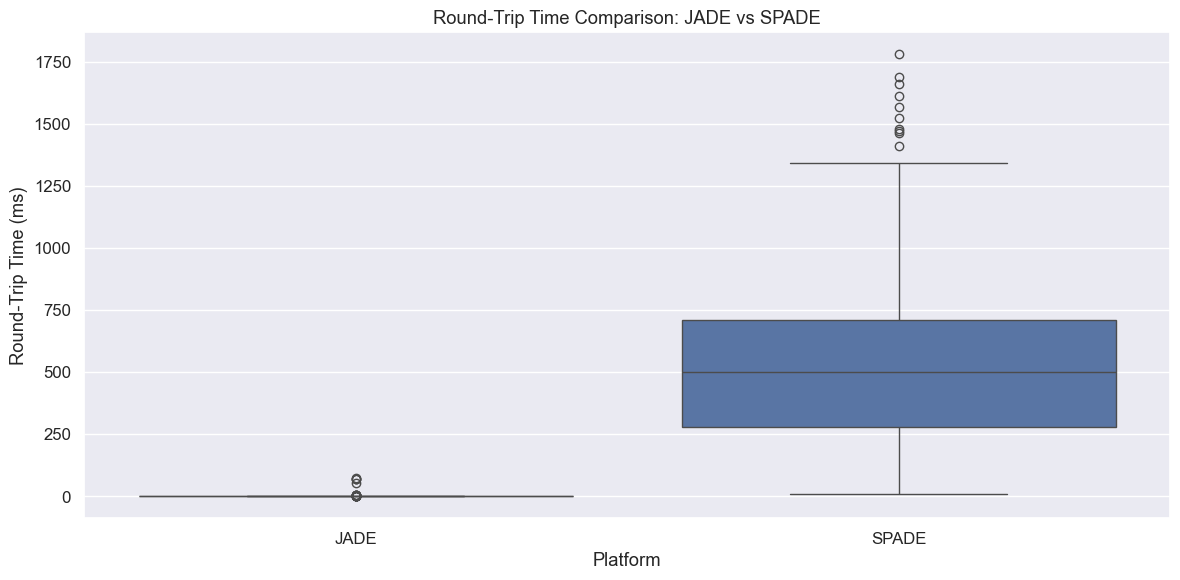

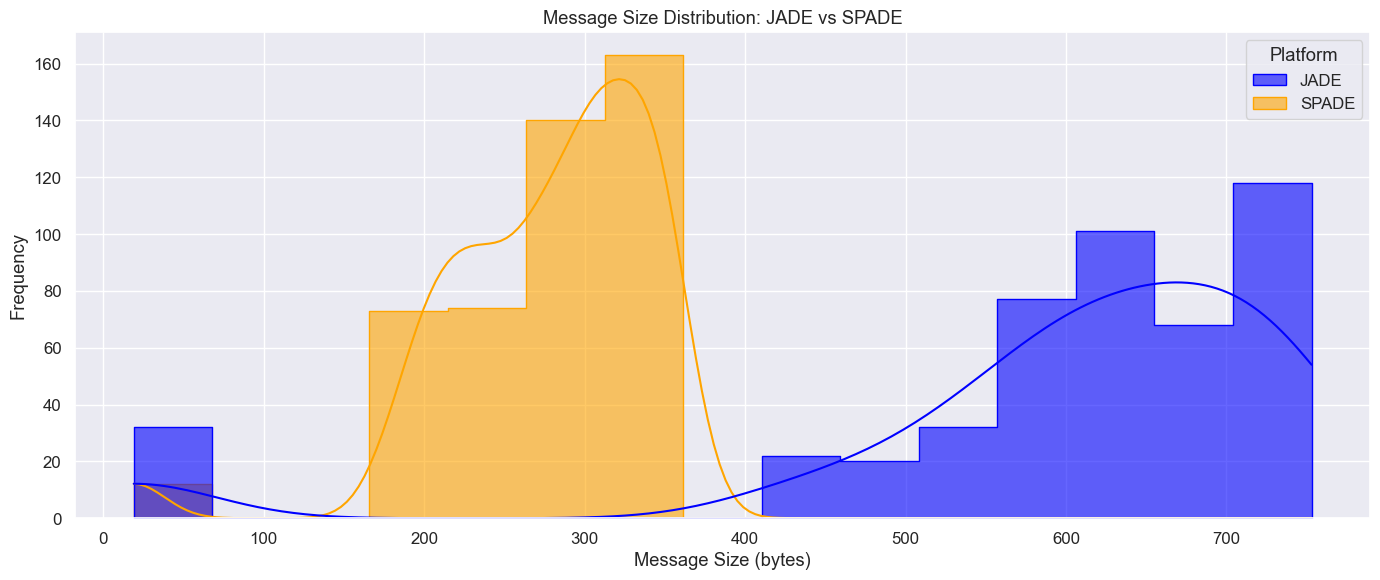

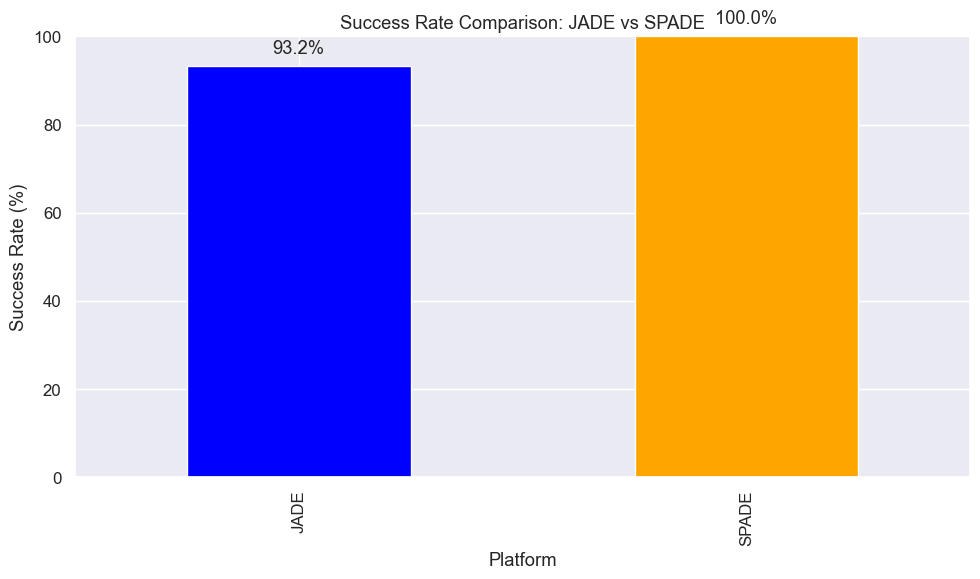

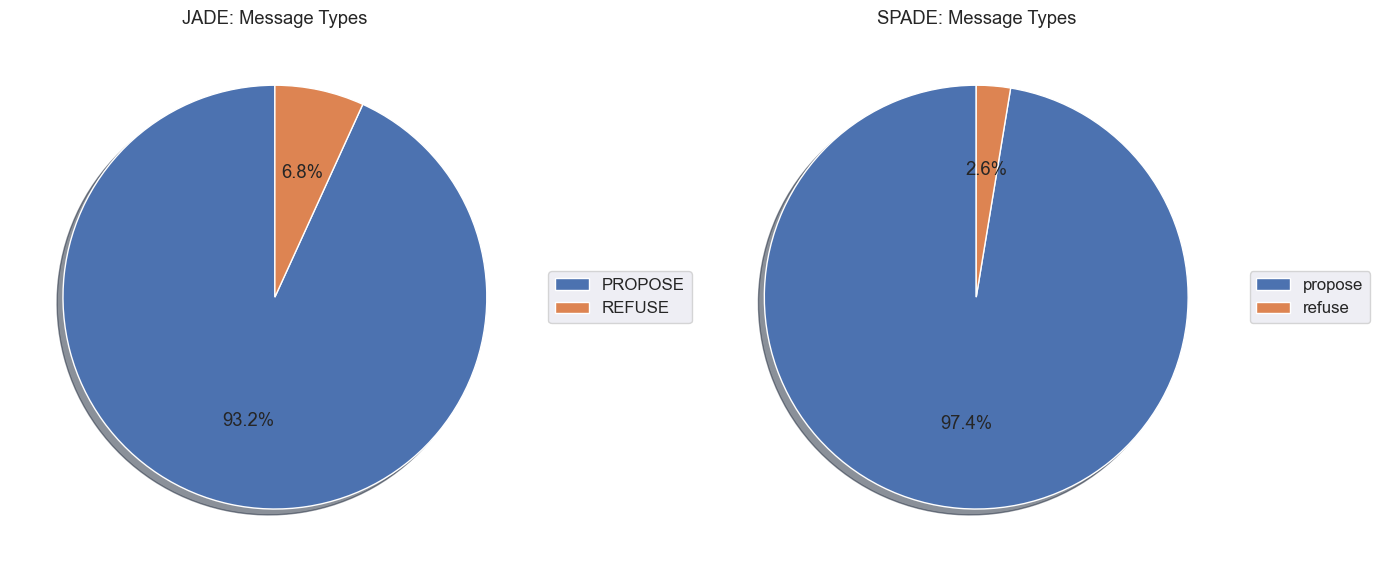

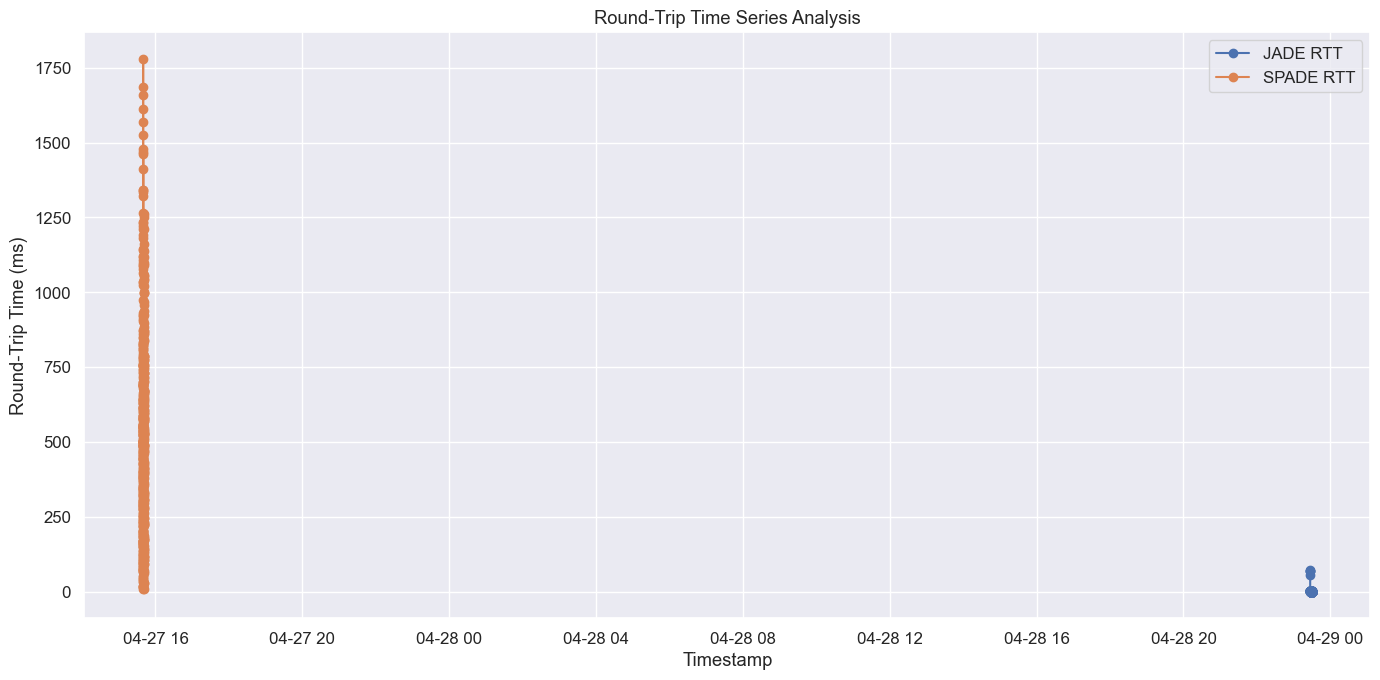

<Figure size 1200x1000 with 0 Axes>

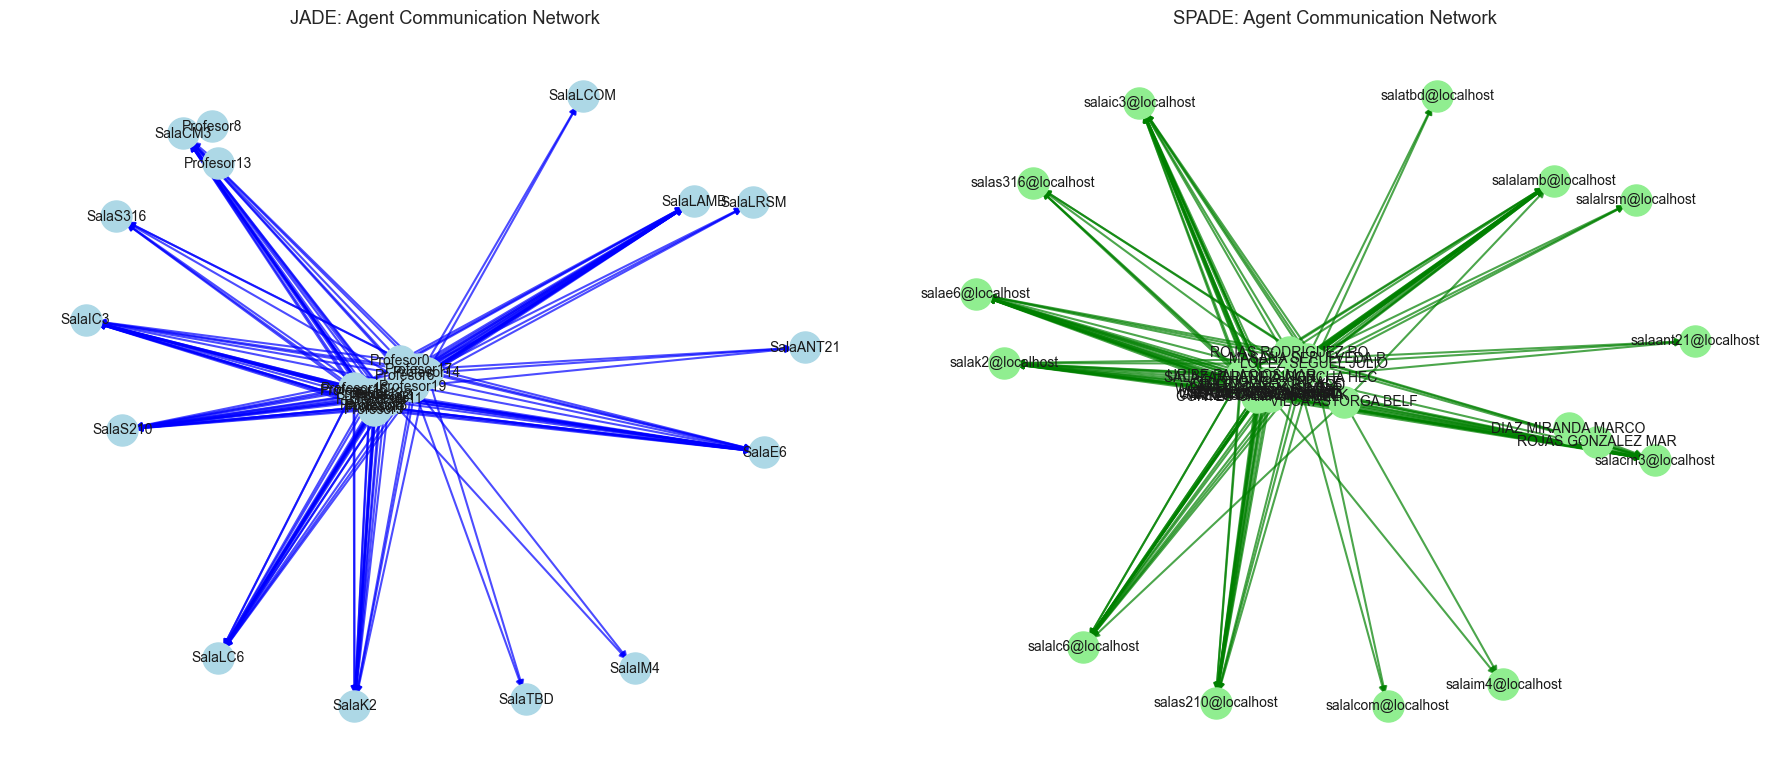


Statistical Comparison:


RTT_ms                              MessageSize_bytes              \
            mean     std   min      max count              mean     std min   
Platform                                                                      
JADE        1.47    6.88  0.14    71.59   470            593.32  176.13  19   
SPADE     531.35  337.84  7.21  1780.26   462            277.35   65.90  19   

              Success        
          max    mean count  
Platform                     
JADE      753    0.93   470  
SPADE     357    1.00   462


T-test for RTT difference between JADE and SPADE:
t-statistic: -33.7053
p-value: 0.0000
Conclusion: There is a statistically significant difference in RTT between the platforms.

Additional MAS-specific Metrics:

Average message size by performative type:


Performative,PROPOSE,REFUSE,propose,refuse
Platform,,,,
JADE,635.283105,19.0,NaN,NaN
SPADE,NaN,NaN,284.24,19.0



Success rate by receiver:


Receiver,SalaANT21,SalaCM3,SalaE6,SalaIC3,SalaIM4,SalaK2,SalaLAMB,SalaLC6,SalaLCOM,SalaLRSM,...,salaic3@localhost,salaim4@localhost,salak2@localhost,salalamb@localhost,salalc6@localhost,salalcom@localhost,salalrsm@localhost,salas210@localhost,salas316@localhost,salatbd@localhost
Platform,,,,,,,,,,,,,,,,,,,,,
JADE,1.0,0.81,1.0,1.0,1.0,0.69,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPADE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0



----- Conclusion -----
Based on the analysis above, here are the key findings:
1. JADE shows better average round-trip time (RTT) by 529.89 ms.
2. SPADE has a higher success rate by 6.81%.
3. SPADE has smaller average message size by 315.97 bytes.

Recommendations:
- Consider extending the data collection period to get more representative results
- Add more metrics like CPU/memory usage during agent execution
- Track message queue lengths and processing times
- Consider analyzing the semantics of conversations (not just metrics)


In [7]:
# MAS Comparison Analysis: JADE vs SPADE
# ====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
import io
from IPython.display import display, HTML

# Set the style for better visualizations
plt.style.use('ggplot')
sns.set(font_scale=1.1)

# Sample data (replace with paths to your actual JADE and SPADE CSV files)
jade_sample = "rtt/small/jade.csv"
spade_sample = "rtt/small/spade.csv"
# Function to load the data (from file or string)
def load_data(source, is_file=False):
    if is_file:
        return pd.read_csv(source, encoding="latin1")
    else:
        return pd.read_csv(io.StringIO(source))

# Load the data
jade_df = load_data(jade_sample, True)
spade_df = load_data(spade_sample, True)

# Add a column to identify the platform
jade_df['Platform'] = 'JADE'
spade_df['Platform'] = 'SPADE'

# Convert timestamps to datetime objects
jade_df['Timestamp'] = pd.to_datetime(jade_df['Timestamp'])
spade_df['Timestamp'] = pd.to_datetime(spade_df['Timestamp'])

# convert the format of jade ms from 44,5 to 44.5
jade_df['RTT_ms'] = jade_df['RTT_ms'].str.replace(',', '.').astype(float)

# Combine the datasets for easier comparison
combined_df = pd.concat([jade_df, spade_df], ignore_index=True)

# Display basic information about the datasets
print("JADE Dataset Sample:")
display(jade_df.head())

print("\nSPADE Dataset Sample:")
display(spade_df.head())

print("\nBasic Statistics:")
display(combined_df.groupby('Platform').describe())

# ===== Create Visualizations =====

# 1. RTT Comparison Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Platform', y='RTT_ms', data=combined_df)
plt.title('Round-Trip Time Comparison: JADE vs SPADE')
plt.ylabel('Round-Trip Time (ms)')
plt.tight_layout()
# plt.savefig('rtt_comparison.png')
plt.show()

# 2. Message Size Distribution
plt.figure(figsize=(14, 6))
sns.histplot(data=combined_df, x='MessageSize_bytes', hue='Platform', kde=True, bins=15, 
             alpha=0.6, element='step', palette=['blue', 'orange'])
plt.title('Message Size Distribution: JADE vs SPADE')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Frequency')
plt.tight_layout()
# plt.savefig('message_size_dist.png')
plt.show()

# 3. Success Rate Bar Chart
success_rates = combined_df.groupby('Platform')['Success'].mean() * 100
plt.figure(figsize=(10, 6))
success_rates.plot(kind='bar', color=['blue', 'orange'])
plt.title('Success Rate Comparison: JADE vs SPADE')
plt.ylabel('Success Rate (%)')
plt.ylim(0, 100)  # Set y-axis from 0 to 100%
for i, v in enumerate(success_rates):
    plt.text(i, v + 3, f'{v:.1f}%', ha='center')
plt.tight_layout()
# plt.savefig('success_rate.png')
plt.show()

# 4. Performative Distribution
jade_perf = jade_df['Performative'].value_counts()
spade_perf = spade_df['Performative'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
jade_perf.plot.pie(autopct='%1.1f%%', ax=ax1, startangle=90, shadow=True, labels=None)
ax1.set_title('JADE: Message Types')
ax1.set_ylabel('')
ax1.legend(jade_perf.index, loc='center left', bbox_to_anchor=(1, 0.5))

spade_perf.plot.pie(autopct='%1.1f%%', ax=ax2, startangle=90, shadow=True, labels=None)
ax2.set_title('SPADE: Message Types')
ax2.set_ylabel('')
ax2.legend(spade_perf.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
# plt.savefig('performative_dist.png')
plt.show()

# 5. Time Series Analysis
plt.figure(figsize=(14, 7))
for platform, group in combined_df.groupby('Platform'):
    plt.plot(group['Timestamp'], group['RTT_ms'], 
             marker='o', linestyle='-', label=f'{platform} RTT')
plt.title('Round-Trip Time Series Analysis')
plt.xlabel('Timestamp')
plt.ylabel('Round-Trip Time (ms)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('rtt_timeseries.png')
plt.show()

# 6. Agent Communication Network
plt.figure(figsize=(12, 10))

# Create a graph for each platform
G_jade = nx.DiGraph()
G_spade = nx.DiGraph()

# Add edges for JADE (sender -> receiver)
for _, row in jade_df.iterrows():
    if not G_jade.has_edge(row['Sender'], row['Receiver']):
        G_jade.add_edge(row['Sender'], row['Receiver'], weight=1)
    else:
        G_jade[row['Sender']][row['Receiver']]['weight'] += 1

# Add edges for SPADE
for _, row in spade_df.iterrows():
    if not G_spade.has_edge(row['Sender'], row['Receiver']):
        G_spade.add_edge(row['Sender'], row['Receiver'], weight=1)
    else:
        G_spade[row['Sender']][row['Receiver']]['weight'] += 1

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Layout for the graphs
pos_jade = nx.spring_layout(G_jade, seed=42)
pos_spade = nx.spring_layout(G_spade, seed=42)

# Draw JADE network
nx.draw_networkx_nodes(G_jade, pos_jade, node_size=500, node_color='lightblue', ax=ax1)
nx.draw_networkx_edges(G_jade, pos_jade, width=1.5, alpha=0.7, edge_color='blue', ax=ax1)
nx.draw_networkx_labels(G_jade, pos_jade, font_size=10, font_family='sans-serif', ax=ax1)
ax1.set_title('JADE: Agent Communication Network')
ax1.axis('off')

# Draw SPADE network
nx.draw_networkx_nodes(G_spade, pos_spade, node_size=500, node_color='lightgreen', ax=ax2)
nx.draw_networkx_edges(G_spade, pos_spade, width=1.5, alpha=0.7, edge_color='green', ax=ax2)
nx.draw_networkx_labels(G_spade, pos_spade, font_size=10, font_family='sans-serif', ax=ax2)
ax2.set_title('SPADE: Agent Communication Network')
ax2.axis('off')

plt.tight_layout()
# plt.savefig('communication_network.png')
plt.show()

# ===== Statistical Comparison =====

# 1. Basic statistical comparison
stat_comparison = combined_df.groupby('Platform').agg({
    'RTT_ms': ['mean', 'std', 'min', 'max', 'count'],
    'MessageSize_bytes': ['mean', 'std', 'min', 'max'],
    'Success': ['mean', 'count']
}).round(2)

print("\nStatistical Comparison:")
display(stat_comparison)

# 2. Perform t-test on RTT between platforms
from scipy import stats

jade_rtt = jade_df['RTT_ms']
spade_rtt = spade_df['RTT_ms']

t_stat, p_value = stats.ttest_ind(jade_rtt, spade_rtt, equal_var=False)

print(f"\nT-test for RTT difference between JADE and SPADE:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusion: There is a statistically significant difference in RTT between the platforms.")
else:
    print("Conclusion: There is no statistically significant difference in RTT between the platforms.")

# 3. Additional comparison metrics
print("\nAdditional MAS-specific Metrics:")

# Average message size by performative
print("\nAverage message size by performative type:")
display(combined_df.groupby(['Platform', 'Performative'])['MessageSize_bytes'].mean().unstack())

# Success rate by receiver
print("\nSuccess rate by receiver:")
success_by_receiver = combined_df.groupby(['Platform', 'Receiver'])['Success'].mean().unstack().round(2)
display(success_by_receiver)

# ===== Conclusion and Recommendations =====

print("\n----- Conclusion -----")
print("Based on the analysis above, here are the key findings:")

# Determine which platform has better average RTT
better_rtt = "JADE" if jade_df['RTT_ms'].mean() < spade_df['RTT_ms'].mean() else "SPADE"
rtt_diff = abs(jade_df['RTT_ms'].mean() - spade_df['RTT_ms'].mean())

print(f"1. {better_rtt} shows better average round-trip time (RTT) by {rtt_diff:.2f} ms.")

# Compare success rates
better_success = "JADE" if jade_df['Success'].mean() > spade_df['Success'].mean() else "SPADE"
success_diff = abs(jade_df['Success'].mean() - spade_df['Success'].mean()) * 100

print(f"2. {better_success} has a higher success rate by {success_diff:.2f}%.")

# Compare message sizes
better_size = "JADE" if jade_df['MessageSize_bytes'].mean() < spade_df['MessageSize_bytes'].mean() else "SPADE"
size_diff = abs(jade_df['MessageSize_bytes'].mean() - spade_df['MessageSize_bytes'].mean())

print(f"3. {better_size} has smaller average message size by {size_diff:.2f} bytes.")

print("\nRecommendations:")
print("- Consider extending the data collection period to get more representative results")
print("- Add more metrics like CPU/memory usage during agent execution")
print("- Track message queue lengths and processing times")
print("- Consider analyzing the semantics of conversations (not just metrics)")